**Initialization**

In [1]:
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt

**Task 1: Data set**

Training inputs shape: (60000, 28, 28)
Training labels shape: (60000,)
Test inputs shape: (10000, 28, 28)
Test labels shape: (10000,)


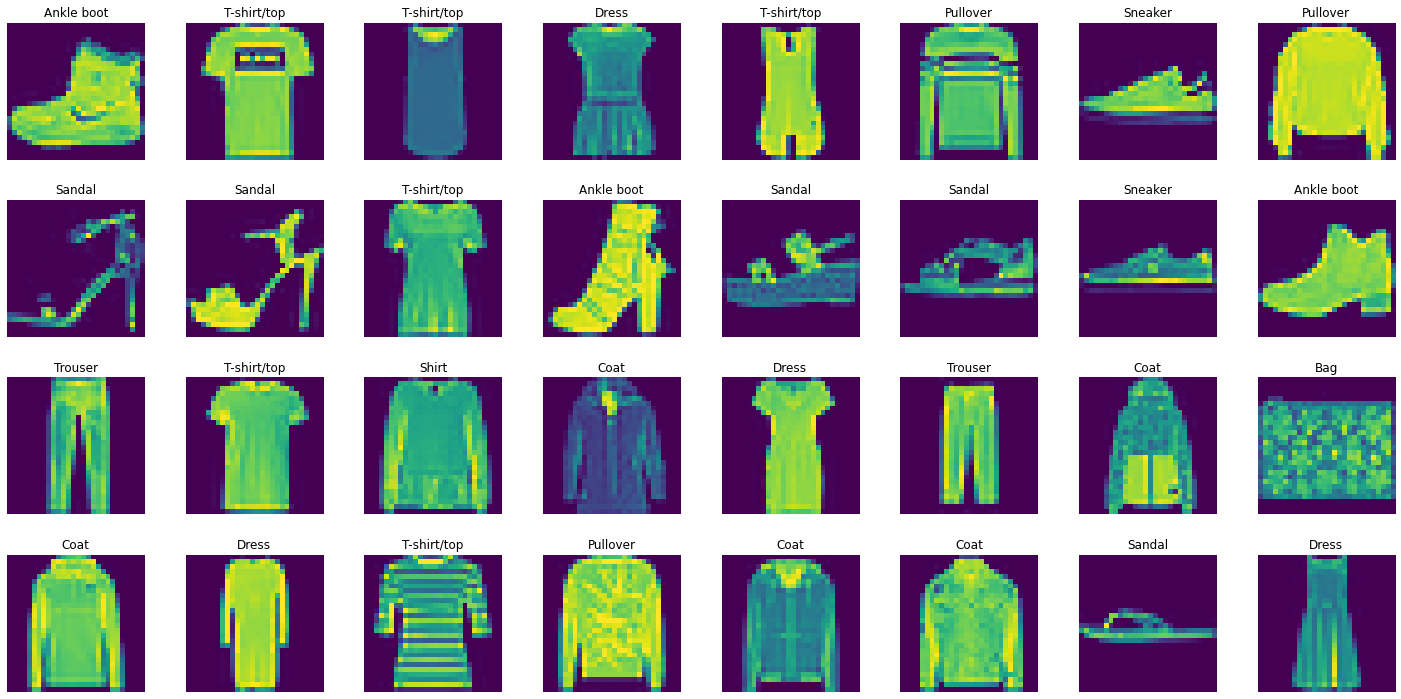

In [2]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

print("Training inputs shape: " + str(training_inputs.shape))
print("Training labels shape: " + str(training_labels.shape))
print("Test inputs shape: " + str(test_inputs.shape))
print("Test labels shape: " + str(test_labels.shape))

label_encoding = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, ax = plt.subplots(4, 8, figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(32):
  image = training_inputs[i]
  label = label_encoding[training_labels[i]]

  ax[i].imshow(image)
  ax[i].set_title(label)
  ax[i].axis("off")

Several functions which generate the different generator and discriminator samples replace the classical data pipeline. These functions also cover the necessary pre-processing steps.  

In [3]:
# This function returns 6000 real images of the selected_class given by the training dataset.
def load_real_images(selected_class):
  # Load the complete training dataset (inputs and labels).
  (train_inputs, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

  # Only take images with the same label as the selected_class. 
  selected_images = train_labels == selected_class
  selected_images = train_inputs[selected_images]

  # Add last dimension to obtain the necessary image shape.
  selected_images = tf.expand_dims(selected_images, -1)

  # Normalize the images to the range (-1, 1).
  selected_images = 2 * (selected_images / 255) - 1
  return selected_images


# This function returns n_samples of real_images for the training of the discriminator.
# It is distinguished between a classical and a Wasserstein GAN by the boolean wasserstein.
def generate_real_samples(real_images, n_samples, wasserstein = False):
  # Select n_samples randomly from the 6000 possible real_images.
  random_samples = np.random.randint(0, real_images.shape[0], n_samples)
  random_real_imgs = []
  for i in range(len(random_samples)):
    random_real_imgs.append(real_images[random_samples[i]])

  # Set the targets (labels) of the real samples. 1 for a classical GAN and -1 for a
  # Wasserstein GAN.
  real_img_targets = tf.ones(shape = [n_samples], dtype = tf.dtypes.int8)           
  if wasserstein == True:
    real_img_targets = -1 * real_img_targets
  
  # Create a tensorflow dataset and batch and prefetch it.
  real_img_inputs_dataset = tf.data.Dataset.from_tensor_slices(random_real_imgs)
  real_img_targets_dataset = tf.data.Dataset.from_tensor_slices(real_img_targets)
  real_img_dataset = tf.data.Dataset.zip((real_img_inputs_dataset, real_img_targets_dataset))
  real_img_dataset = real_img_dataset.batch(n_samples).prefetch(n_samples)
  return real_img_dataset


# This function returns n_samples of a latent space vector. The size of each latent space is 
# defined by the parameter size_of_latent_space.
def generate_latent_points(size_of_latent_space, n_samples):
  latent_spaces = tf.random.normal(shape = [size_of_latent_space * n_samples])
  latent_spaces = tf.reshape(latent_spaces, shape = [n_samples, size_of_latent_space])
  return latent_spaces


# This function returns n_samples of latent space vectors for the training of the generator.
# It is distinguished between a classical and a Wasserstein GAN by the boolean wasserstein.
def generate_generator_samples(size_of_latent_space, n_samples, wasserstein = False):
  # Generate n_samples of latent space vectors.
  generator_inputs = generate_latent_points(size_of_latent_space, n_samples)

  # Set the targets (labels) of the latent space vectors. 1 for a classical GAN and -1 for a
  # Wasserstein GAN. These are the same as for the real samples, since the goal of the 
  # generator is to fool the discriminator.
  generator_targets = tf.ones(shape = [n_samples], dtype = tf.dtypes.int8) 
  if wasserstein == True:
    generator_targets = -1 * generator_targets             

  # Create a tensorflow dataset and batch and prefetch it.
  generator_input_dataset = tf.data.Dataset.from_tensor_slices(generator_inputs)
  generator_target_dataset = tf.data.Dataset.from_tensor_slices(generator_targets)
  generator_dataset = tf.data.Dataset.zip((generator_input_dataset, generator_target_dataset))
  generator_dataset = generator_dataset.batch(n_samples).prefetch(n_samples)                        
  return generator_dataset


# This function returns n_samples of generated fake images for the training of the discriminator.
# It is distinguished between a classical and a Wasserstein GAN by the boolean wasserstein.
def generate_fake_samples(generator, size_of_latent_space, n_samples, wasserstein = False):
  # Generate n_samples of latent space vectors.
  latent_spaces = generate_latent_points(size_of_latent_space, n_samples)

  # Generate n_samples of fake images by calling the generator.
  generator_input_dataset = tf.data.Dataset.from_tensor_slices(latent_spaces)  
  generator_input_dataset = generator_input_dataset.batch(n_samples).prefetch(n_samples)
  fake_imgs = []
  for input in generator_input_dataset:
    fake_img = generator(input, training = False)       
    fake_imgs.append(fake_img)
  fake_imgs = tf.reshape(fake_imgs, shape = [n_samples, 28, 28, 1])

  # Set the targets (labels) of the fake samples. 0 for a classical GAN and 1 for a
  # Wasserstein GAN.
  fake_img_targets = tf.zeros(shape = [n_samples], dtype = tf.dtypes.int8)
  if wasserstein == True:
    fake_img_targets = tf.ones(shape = [n_samples], dtype = tf.dtypes.int8)        

  # Create a tensorflow dataset and batch and prefetch it.
  fake_img_inputs_dataset = tf.data.Dataset.from_tensor_slices(fake_imgs)
  fake_img_targets_dataset = tf.data.Dataset.from_tensor_slices(fake_img_targets)
  fake_img_dataset = tf.data.Dataset.zip((fake_img_inputs_dataset, fake_img_targets_dataset))
  fake_img_dataset = fake_img_dataset.batch(n_samples).prefetch(n_samples)
  return fake_img_dataset

**Task 2: Model**

Class Generator

In [4]:
# The class Generator defines the generator of a GAN. There are no differences between a classical and a 
# Wasserstein GAN, so the same class is used for both versions here. But one could also define two different
# versions to design them independent from each other.
class Generator(tf.keras.layers.Layer): 
  
  def __init__(self):
    super(Generator, self).__init__()

    # Take a latent space vector and reshape it into the image shape (7, 7, 1).
    self.dense_layer = tf.keras.layers.Dense(49, 
                                             kernel_initializer = tf.keras.initializers.RandomNormal(stddev = 0.02))
    self.activ_1 = tf.keras.activations.relu 
    self.reshape_layer = tf.keras.layers.Reshape((7, 7, 1))  

    # Upsampling by transposed convolution.
    self.transp_conv_1 = tf.keras.layers.Conv2DTranspose(filters = 128,
                                                         kernel_size = 4,               
                                                         strides = 2,
                                                         activation = None,
                                                         padding = 'same',
                                                         kernel_initializer = tf.keras.initializers.RandomNormal(stddev = 0.02))
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                     
    self.activ_2 = tf.keras.activations.relu 

    self.transp_conv_2 = tf.keras.layers.Conv2DTranspose(filters = 128,
                                                         kernel_size = 4,                 
                                                         strides = 2,
                                                         activation = None,
                                                         padding = 'same',
                                                         kernel_initializer = tf.keras.initializers.RandomNormal(stddev = 0.02))     
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                     
    self.activ_3 = tf.keras.activations.relu 

    # The output is a generated image with shape (28, 28, 1) and tanh activation due to the normalized image range of (-1, 1).
    self.output_layer = tf.keras.layers.Conv2D(filters = 1,
                                               kernel_size = 7,
                                               strides = 1,
                                               activation = tf.keras.activations.tanh,  
                                               padding = 'same',
                                               kernel_initializer = tf.keras.initializers.RandomNormal(stddev = 0.02))  


  # This function conducts a forward step of the generator.
  @tf.function
  def call(self, x, training):
    x = self.dense_layer(x)
    x = self.activ_1(x)
    x = self.reshape_layer(x)

    x = self.transp_conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_2(x)

    x = self.transp_conv_2(x)
    x = self.batch_norm_2(x, training)
    x = self.activ_3(x)

    x = self.output_layer(x)
    return x    

Class Discriminator

In [5]:
# The class Discriminator defines the discriminator of a classical GAN.
class Discriminator(tf.keras.layers.Layer): 
  
  def __init__(self):
    super(Discriminator, self).__init__()       

    # Take an image with shape (28, 28, 1) and apply convolutions to it.
    self.conv_1 = tf.keras.layers.Conv2D(filters = 48,
                                         kernel_size = 4,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',  
                                         kernel_initializer = tf.keras.initializers.RandomNormal(),                              
                                         input_shape = (28, 28, 1))     
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                     
    self.activ_1 = tf.keras.activations.tanh 
    self.dropout_1 = tf.keras.layers.Dropout(rate = 0.5) 

    self.conv_2 = tf.keras.layers.Conv2D(filters = 48,
                                         kernel_size = 4,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',  
                                         kernel_initializer = tf.keras.initializers.RandomNormal())
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                     
    self.activ_2 = tf.keras.activations.tanh        

    # The output is the probability that the given image is fake or real. 
    # Therefore the sigmoid activation is used.
    self.flatten_layer = tf.keras.layers.Flatten()
    self.dropout_2 = tf.keras.layers.Dropout(rate = 0.5) 
    self.output_layer = tf.keras.layers.Dense(1,
                                              activation = tf.keras.activations.sigmoid)   


  # This function conducts a forward step of the discriminator.
  @tf.function
  def call(self, x, training):
    x = self.conv_1(x)  
    x = self.batch_norm_1(x, training)                                    
    x = self.activ_1(x)
    x = self.dropout_1(x, training)

    x = self.conv_2(x)
    x = self.batch_norm_2(x, training)                                   
    x = self.activ_2(x)  

    x = self.flatten_layer(x)
    x = self.dropout_2(x, training)
    x = self.output_layer(x)
    return x                 

Class WassersteinDiscriminator

In [6]:
# Description: The class WassersteinDiscriminator defines the "discriminator" (approximator to the Wasserstein-distance) 
# of a Wasserstein GAN. 
class WassersteinDiscriminator(tf.keras.layers.Layer): 
  
  def __init__(self):
    super(WassersteinDiscriminator, self).__init__()       

    # Take an image with shape (28, 28, 1) and apply convolutions to it. Since it is a Wasserstein GAN, weight clipping 
    # is applied by defining the kernel_constraint and bias_constraint arguments.
    self.conv_1 = tf.keras.layers.Conv2D(filters = 64,
                                         kernel_size = 4,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',  
                                         kernel_initializer = tf.keras.initializers.RandomNormal(),   
                                         kernel_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01),
                                         bias_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01),                                
                                         input_shape = (28, 28, 1))     
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                     
    self.activ_1 = tf.keras.activations.tanh  

    self.conv_2 = tf.keras.layers.Conv2D(filters = 64,
                                         kernel_size = 4,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',  
                                         kernel_initializer = tf.keras.initializers.RandomNormal(),       
                                         kernel_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01),
                                         bias_constraint = tf.keras.constraints.MinMaxNorm(min_value = -0.01, max_value = 0.01))
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                     
    self.activ_2 = tf.keras.activations.tanh       

    # The output is a score function instead of a probability for binary classification. 
    # Therefore a linear activation is used.
    self.flatten_layer = tf.keras.layers.Flatten()
    self.output_layer = tf.keras.layers.Dense(1,
                                              activation = None)   


  # This function conducts a forward step of the discriminator.
  @tf.function
  def call(self, x, training):
    x = self.conv_1(x)  
    x = self.batch_norm_1(x, training)                                    
    x = self.activ_1(x)

    x = self.conv_2(x)
    x = self.batch_norm_2(x, training)                                   
    x = self.activ_2(x)  

    x = self.flatten_layer(x)
    x = self.output_layer(x)
    return x          

**Task 3: Training**

Training step functions for generator and discriminator. 

In [7]:
# This function conducts a forward-step and the backpropagation of a generator. Additionally, the average training loss is determined.
def generator_training_step(generator, discriminator, dataset, loss_fn, optimizer, gen_training = True, dis_training = False):
  training_losses = []
  for (input, target) in dataset:
    with tf.GradientTape() as tape:
      # Generate fake images by calling the generator with the given dataset inputs.
      fake_img = generator(input, gen_training)
      # Get the corresponding predictions by calling the discriminator.   
      prediction = discriminator(fake_img, dis_training)

      # Determine the loss with the given dataset targets.
      current_training_loss = loss_fn(target, prediction)  
      gradients = tape.gradient(current_training_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    training_losses.append(current_training_loss.numpy())
  
  training_loss = np.mean(training_losses)
  return training_loss
  

# This function conducts a forward-step and the backpropagation of a discriminator. Additionally, the average training loss is determined.
def discriminator_training_step(discriminator, dataset, loss_fn, optimizer, training = True):
  training_losses = []
  for (input, target) in dataset:
    with tf.GradientTape() as tape:
      # Get predictions by calling the discriminator with the given dataset inputs. 
      prediction = discriminator(input, training)     

      # Determine the loss with the given dataset targets.                                                                                                 
      current_training_loss = loss_fn(target, prediction)   
      gradients = tape.gradient(current_training_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
    training_losses.append(current_training_loss.numpy())
  
  training_loss = np.mean(training_losses)
  return training_loss

Both GANs are only trained on one class of the Fashion MNIST dataset to obtain fairly good results. This class is defined by the parameter of the load_real_images function. Both GANs architectures are specialized on the class Sandal (5) - after one day of messy optimization. Thus, the results for the other classes are not very good. In the next code snippet the training of a classical GAN is conducted. 

Step 92


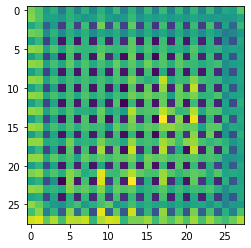

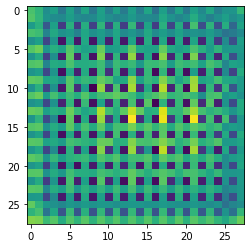

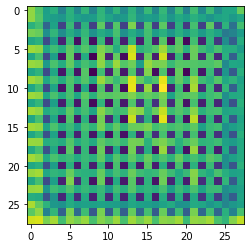

Generator loss: 0.23735157
Discriminator loss: 0.25365746
Step 185


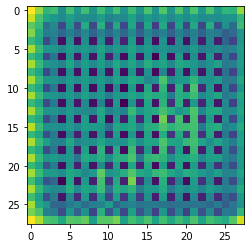

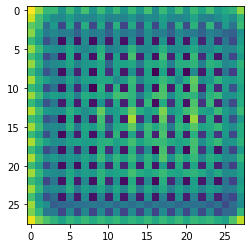

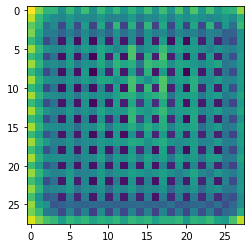

Generator loss: 0.01962008
Discriminator loss: 0.029020924
Step 278


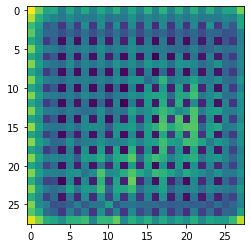

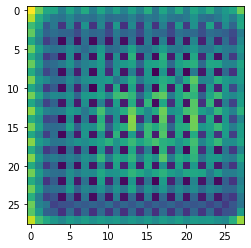

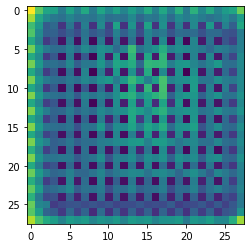

Generator loss: 0.0025469866
Discriminator loss: 0.014458874
Step 371


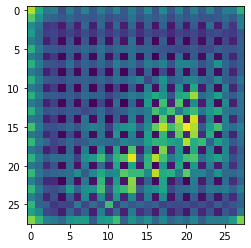

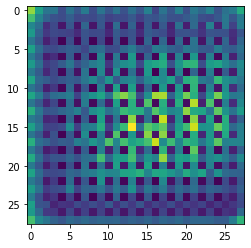

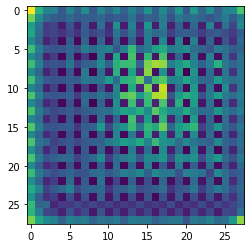

Generator loss: 0.0027309489
Discriminator loss: 0.012641063
Step 464


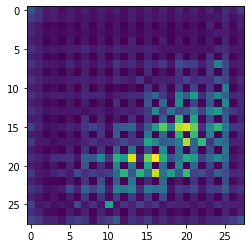

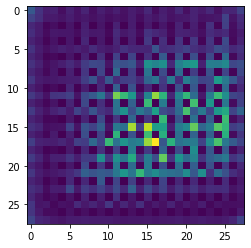

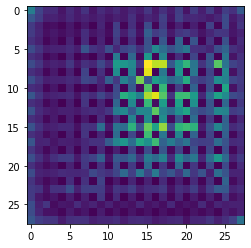

Generator loss: 0.0076582693
Discriminator loss: 0.012764062
Step 557


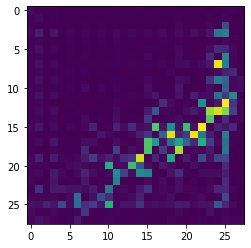

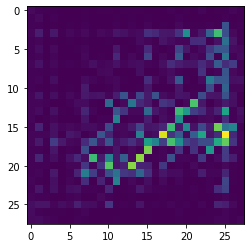

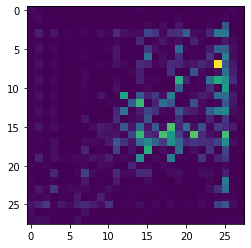

Generator loss: 0.08103008
Discriminator loss: 0.02429554


In [8]:
tf.keras.backend.clear_session()

# Parameters which are identical for classical and Wasserstein GAN are only defined once in the following.
real_images = load_real_images(5)   # class 5 = Sandal
size_of_latent_space = 49
batch_size = 64
# n_batches_of_samples batches can be created from the real_images. 
n_batches_of_samples = int(real_images.shape[0] / batch_size)
# The discriminator gets a half batch of real and a half batch of fake samples.
half_batch_size = int(batch_size / 2)

# A dataset of 3 latent space vectors is created to evaluate training by plotting the generated images.
evalation_latent_spaces = generate_latent_points(size_of_latent_space, 3)
generator_evaluation_dataset = tf.data.Dataset.from_tensor_slices(evalation_latent_spaces)  
generator_evaluation_dataset = generator_evaluation_dataset.batch(3).prefetch(3)

# Parameters which are different for classical and Wasserstein GAN are defined in the following.
# Here: Classcial GAN
wasserstein = False   # Boolean to define whether a classical GAN or a Wasserstein GAN is trained.
cla_generator = Generator()
cla_discriminator = Discriminator()
n_epochs = 6
n_steps = n_batches_of_samples * n_epochs
# Defines how much more often the discriminator should be trained compared to the generator.
n_discriminator = 1   
learning_rate = 0.000068
loss_fn = tf.keras.losses.BinaryCrossentropy()                             
optimizer = tf.keras.optimizers.Adam(learning_rate) 
cla_generator_losses = []
cla_discriminator_losses = []
cla_generator_losses_for_vis = []
cla_discriminator_losses_for_vis = []

# Training loop
for step in range(n_steps):
  # Nested for-loop to train the discriminator more often than the generator, if desired.
  for i in range(n_discriminator):
    # Training with half_batch_size real samples.
    real_samples_dataset = generate_real_samples(real_images, half_batch_size, wasserstein)
    discriminator_loss_1 = discriminator_training_step(cla_discriminator, real_samples_dataset, loss_fn, optimizer, training = True)
    cla_discriminator_losses.append(discriminator_loss_1)         

    # Training with half_batch_size fake samples.
    fake_samples_dataset = generate_fake_samples(cla_generator, size_of_latent_space, half_batch_size, wasserstein)           
    discriminator_loss_2 = discriminator_training_step(cla_discriminator, fake_samples_dataset, loss_fn, optimizer, training = True)                               
    cla_discriminator_losses.append(discriminator_loss_2)     

  # Training of the generator with batch_size latent space vectors.
  generator_dataset = generate_generator_samples(size_of_latent_space, batch_size, wasserstein)
  generator_loss = generator_training_step(cla_generator, cla_discriminator, generator_dataset,  loss_fn, optimizer, gen_training = True, dis_training = False)
  cla_generator_losses.append(generator_loss)

  # Output to keep track of the training progress.
  if step % n_batches_of_samples == (n_batches_of_samples - 1):
    print('Step ' + str(step))
    # Plot the 3 generated images based on the latent space vectors of the evaluation dataset.
    fake_imgs = []
    for input in generator_evaluation_dataset:
      fake_img = cla_generator(input, training = False)
      fake_imgs.append(fake_img)
    for img in fake_imgs:
      plt.imshow(tf.squeeze(img[0]).numpy())
      plt.show()
      plt.imshow(tf.squeeze(img[1]).numpy())
      plt.show()
      plt.imshow(tf.squeeze(img[2]).numpy())
      plt.show()

      # Print the generator and discriminator loss.
      print("Generator loss: " + str(np.mean(cla_generator_losses)))
      print("Discriminator loss: " + str(np.mean(cla_discriminator_losses)))
      cla_generator_losses_for_vis.append(np.mean(cla_generator_losses))
      cla_discriminator_losses_for_vis.append(np.mean(cla_discriminator_losses))
      cla_generator_losses.clear()
      cla_discriminator_losses.clear()

Wasserstein loss function

In [9]:
def wasserstein_loss(target, prediction):
  target = tf.cast(target, dtype = tf.dtypes.float32)
  return tf.keras.backend.mean(target * prediction)

In the next code snippet the training of a Wasserstein GAN is conducted. 

Step 92


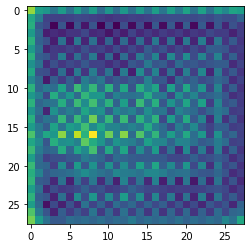

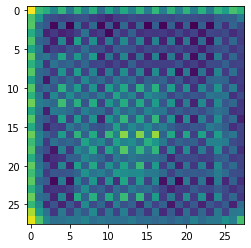

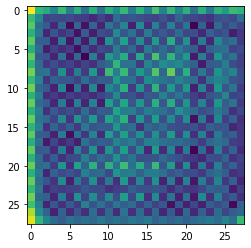

Generator loss: -1.3349724
Discriminator loss: -13.329669
Step 185


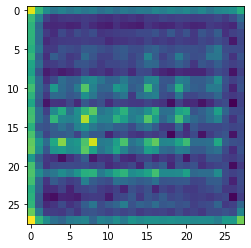

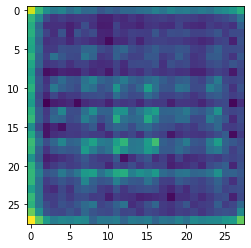

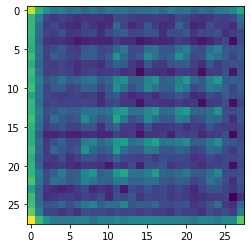

Generator loss: -45.439884
Discriminator loss: -39.99999
Step 278


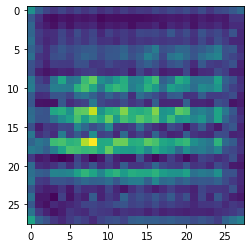

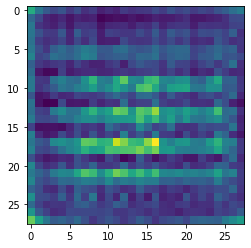

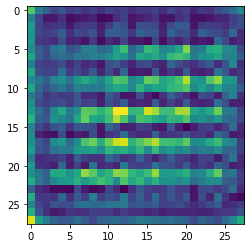

Generator loss: -88.36871
Discriminator loss: -72.41186
Step 371


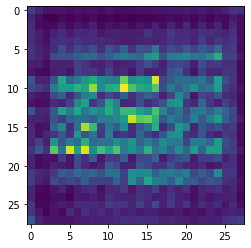

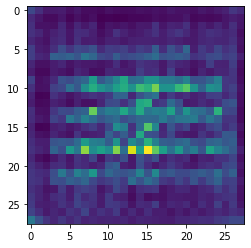

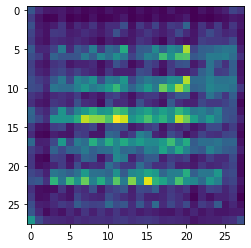

Generator loss: -89.63399
Discriminator loss: -101.7475
Step 464


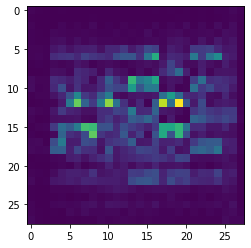

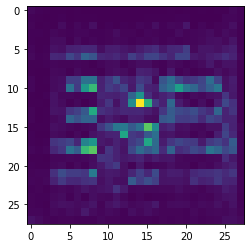

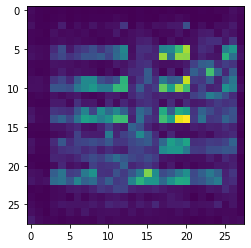

Generator loss: -100.04127
Discriminator loss: -133.46565
Step 557


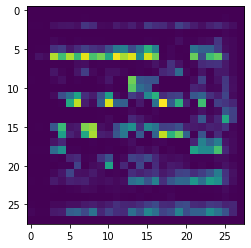

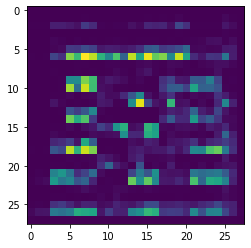

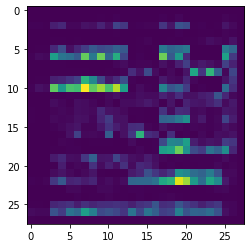

Generator loss: -86.65377
Discriminator loss: -151.66014
Step 650


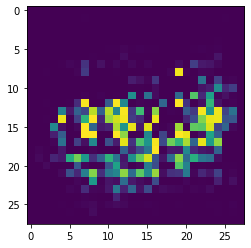

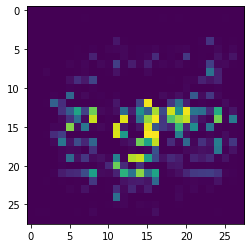

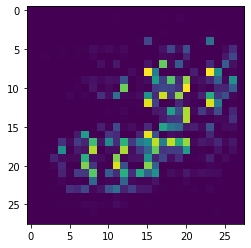

Generator loss: -14.512946
Discriminator loss: -57.842964


In [10]:
tf.keras.backend.clear_session()

# Parameters which are different for classical and Wasserstein GAN are defined in the following.
# Here: Wasserstein GAN
wasserstein = True    # Boolean to define whether a classical GAN or a Wasserstein GAN is trained.
was_generator = Generator()
was_discriminator = WassersteinDiscriminator()
n_epochs = 7 
n_steps = n_batches_of_samples * n_epochs
# Defines how much more often the discriminator should be trained compared to the generator.
n_discriminator = 2                   
learning_rate = 0.00006
loss_fn = wasserstein_loss                          
optimizer = tf.keras.optimizers.RMSprop(learning_rate) 
was_generator_losses = []
was_discriminator_losses = []
was_generator_losses_for_vis = []
was_discriminator_losses_for_vis = []

# Training loop
for step in range(n_steps):
  # Nested for-loop to train the discriminator more often than the generator, if desired.
  for i in range(n_discriminator):
    # Training with half_batch_size real samples.
    real_samples_dataset = generate_real_samples(real_images, half_batch_size, wasserstein)
    discriminator_loss_1 = discriminator_training_step(was_discriminator, real_samples_dataset, loss_fn, optimizer, training = True)
    was_discriminator_losses.append(discriminator_loss_1)         

    # Training with half_batch_size fake samples.
    fake_samples_dataset = generate_fake_samples(was_generator, size_of_latent_space, half_batch_size, wasserstein)           
    discriminator_loss_2 = discriminator_training_step(was_discriminator, fake_samples_dataset, loss_fn, optimizer, training = True)                               
    was_discriminator_losses.append(discriminator_loss_2)     

  # Training of the generator with batch_size latent space vectors.
  generator_dataset = generate_generator_samples(size_of_latent_space, batch_size, wasserstein)
  generator_loss = generator_training_step(was_generator, was_discriminator, generator_dataset,  loss_fn, optimizer, gen_training = True, dis_training = False)
  was_generator_losses.append(generator_loss)

  # Output to keep track of the training progress.
  if step % n_batches_of_samples == (n_batches_of_samples - 1):
    print('Step ' + str(step))
    # Plot the 3 generated images based on the latent space vectors of the evaluation dataset.
    fake_imgs = []
    for input in generator_evaluation_dataset:
      fake_img = was_generator(input, training = False)
      fake_imgs.append(fake_img)
    for img in fake_imgs:
      plt.imshow(tf.squeeze(img[0]).numpy())
      plt.show()
      plt.imshow(tf.squeeze(img[1]).numpy())
      plt.show()
      plt.imshow(tf.squeeze(img[2]).numpy())
      plt.show()

      # Print the generator and discriminator loss.
      print("Generator loss: " + str(np.mean(was_generator_losses)))
      print("Discriminator loss: " + str(np.mean(was_discriminator_losses)))
      was_generator_losses_for_vis.append(np.mean(was_generator_losses))
      was_discriminator_losses_for_vis.append(np.mean(was_discriminator_losses))
      was_generator_losses.clear()
      was_discriminator_losses.clear()

**Loss Visualization**

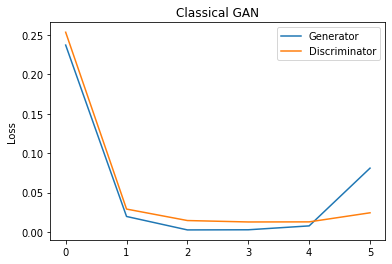

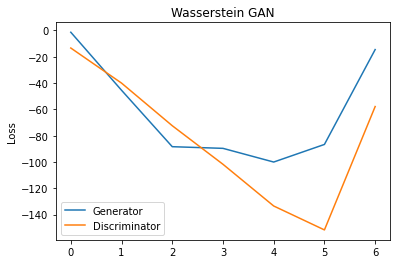

In [11]:
# Figure 1 shows the loss of generator and discriminator for the classical GAN.
# Figure 2 shows the loss of generator and discriminator for the Wasserstein GAN.
plt.figure()
plt.title('Classical GAN')
line1, = plt.plot(cla_generator_losses_for_vis)
line2, = plt.plot(cla_discriminator_losses_for_vis)
plt.ylabel("Loss")
plt.legend((line1, line2),("Generator", "Discriminator"))
plt.show()

plt.figure()
plt.title('Wasserstein GAN')
line1, = plt.plot(was_generator_losses_for_vis)
line2, = plt.plot(was_discriminator_losses_for_vis)
plt.ylabel("Loss")
plt.legend((line1, line2),("Generator", "Discriminator"))
plt.show()